# TP3: NN and CNN with `Pytorch` 

The deadline for report submission is Tuesday, December 22th 2020.

Note: the goal of this TP is to become familiar with 'Pythor' and to understand how to implement Neural Nets with Pyhtor.

We first list the basic function in Pythor and consider a very simple example to understand how Grandient Descent can be implemented. Then we illustrate how set the architecture of neural nets and run it on MNIST dataset. Lastly, we provide an implementation of CNN.

As a homework, we propose you implement logistic regression as a neural net and to also to add dropout in CNN.

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

import random
random.seed(1) #to fix random and have the same results for both of us 

Pytorch operates with tensors instead of numpy arrays. Almost everything you can do with numpy arrays can be acomplished with pytorch tensors.

In [2]:
x = torch.rand(3, 3) # random tensor of size 3 by 3
print(x)

tensor([[0.1642, 0.3461, 0.3179],
        [0.8086, 0.2378, 0.6380],
        [0.9654, 0.0469, 0.2890]])


In [3]:
# We can operate with pytorch tensors pretty much in the same manner as with numpy arrays
x = torch.ones(3,3)
y = torch.ones(3,3) * 4
z = x + y
print(f'This is the result of:\n {x}\n +\n {y} \n = \n {z}')

This is the result of:
 tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
 +
 tensor([[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]]) 
 = 
 tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]])


In [4]:
# again we can operate with tensor indexing as if it was a numpy one

x = torch.ones(3,3) * 5
y = x[-1, :2]
print(f'From \n {x} we can look at the last column and 2 rows \n {y}')



From 
 tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]]) we can look at the last column and 2 rows 
 tensor([5., 5.])


**Example**

As you know, a lot of ML algorithms can be stated as optimization problems.
Let us consider a toy example: imagine that our data is $x = (1, \ldots, 1)^\top \in \mathbb{R}^{5}$ is a vector composed of all ones and a label $y = 1$. We would like to find a weight vector $w \in \mathbb{R}^{5}$ such that the loss function $L(w) = (y - x^\top w)^2$ is minimized.

Of course, this is a simple least squares on a single observation $(x, y)$ and we can compute the result analytically. But it is a good example to understand what pytorch has to offer.

If we are too lazy to compute the analytic expression, we can run the Gradient Descent, which starts from $w_0 = (0, \ldots, 0)^\top$ and proceeds as

$$w_k = w_{k - 1} - \eta \nabla L(w_{k - 1}).$$

So the only thing that we need to know is the gradient of the loss function $L$ evaluated at the point $w_{k - 1}$.
Here how it is done in pytorch.

In [6]:
# Input data
y = torch.ones(1, 1) 
print("y:",y)
x = torch.ones(1, 5)
print("x:",x)

# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these tensors during the backward pass.
w = torch.zeros(5, 1, requires_grad=True) # setting w_0 = (0, ..., 0)^T
print("w:",w)

y_pred = x.mm(w) # inner product of w and x 
print("y_pred:",y_pred)

loss = (y - y_pred).pow(2) # squared loss
print("loss:",loss)

# Use autograd to compute the backward pass. This call will compute the
# gradient of loss with respect to all tensors with requires_grad=True.
# After this call w.grad will be a tensor holding the gradient
# of the loss with respect to w.
loss.backward()

print("w.grad:",w.grad) # Print the gradient

y: tensor([[1.]])
x: tensor([[1., 1., 1., 1., 1.]])
w: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)
y_pred: tensor([[0.]], grad_fn=<MmBackward>)
loss: tensor([[1.]], grad_fn=<PowBackward0>)
w.grad: tensor([[-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.]])


**Question.** Assuming that $w_0 = (0, \ldots, 0)^\top$ compute on paper $\nabla L(w_0)$. Do not include the answer to this question into the report. Just make sure you understand what is going on here.

Once you made sure that ```w.grad``` indeed stores the value of $\nabla L(w_0)$. We can implement the Gradient Descent algorithm with only few lines of code!

In [7]:
# Input data
y = torch.ones(1, 1)
x = torch.ones(1, 5)

w = torch.zeros(5, 1, requires_grad=True) # Initialization: w_0 = (0, ..., 0)^T

lr = .01 # Learning rate a.k.a. the step size
max_iter = 150

for k in range(max_iter):
    loss = (y - x.mm(w)).pow(2) # forward pass
    
        
    loss.backward() # the backward pass
    
    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        w -= lr * w.grad # gradient step
        w.grad.zero_() # after performing operation with gradient we need to erase it
    
    if k % 10 == 9:
        print(f'Iteration {k + 1}/{max_iter}, Current loss: {loss.item()}')
        
print(f'Final result: {w}')

Iteration 10/150, Current loss: 0.150094673037529
Iteration 20/150, Current loss: 0.018248017877340317
Iteration 30/150, Current loss: 0.002218528650701046
Iteration 40/150, Current loss: 0.00026972233899869025
Iteration 50/150, Current loss: 3.279230440966785e-05
Iteration 60/150, Current loss: 3.986556748714065e-06
Iteration 70/150, Current loss: 4.846697265747935e-07
Iteration 80/150, Current loss: 5.8908199207508005e-08
Iteration 90/150, Current loss: 7.173785121494802e-09
Iteration 100/150, Current loss: 8.74024408403784e-10
Iteration 110/150, Current loss: 1.0756195933936397e-10
Iteration 120/150, Current loss: 1.3219647598816664e-11
Iteration 130/150, Current loss: 1.566746732351021e-12
Iteration 140/150, Current loss: 1.7408297026122455e-13
Iteration 150/150, Current loss: 1.2789769243681803e-13
Final result: tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000]], requires_grad=True)


**Question:** Solve the problem $\min_{w \in \mathbb{R}^5}\, (1 - x^\top w)^2$ with $x = (1, \ldots, 1)^\top \in \mathbb{R}^5$ analytically and compare to the result of the Gradient Descent.

**Answer:**

If $x = (1, \ldots, 1)^\top \in \mathbb{R}^5$ and $w = (w_1, \ldots, w_5)^\top \in \mathbb{R}^5$

Let be $f(w) = f(w_1, \dots w_5) = (1 - x^\top w)^2 = (1 - w_1 - w_2 - w_3 - w_4 - w_5)^2$

As $f$ is a positive function, we clearly see that the minimum of $f$ is 0 and is reached for all the points w such as $\sum_{k=1}^5 w_k = 1$ 

In particular the point $w=(0.2, 0.2, 0.2, 0.2, 0.2)$ which is the result of the previous Gradient Descent is one of the minima of the function but the result of the gradient descent would have been different if we had chosen another $w_0 \ne (0, 0, 0, 0, 0)$



**Question:** Recalling the theory of numerical optimization, what is the learning rate ```lr``` that we need to set to ensure the fastest convergence?


**Answer:**

The learning rate $\eta$ is a hyperparameter that determines how fast the algorithm learns. It controls how much to change the model in response to the estimated error each time the model weights are updated following this formula : $w_k = w_{k - 1} - \eta \nabla L(w_{k - 1})$. The learning rate is one of the most important hyperparameter when configuring our neural network. Choosing it is challenging because : 

- **if η is too large**, the model learns too much (rapid learning) and may result in learning a sub-optimal set of weights or an unstable training process  (unable to effectively gradually decrease our loss). The gradient descent can overshoot the local lowest value. It may fail to converge to a good local minimum or may even diverge.

- **if η is too small**, the model learns too little (slow learning) and it may take too long to converge or would even get stuck and unable to converge to a good local minima

**=> To conclude, we must choose a learning rate which is larger enough to converge fast enough but not to large to prevent from rapid learning (being unable to converge to a good minimum). To choose it, we have to test different hyperparameters and define which is the best compromise ("hyperparameter tuning").**

*Source : [here](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) and [here](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/)*



**Question:** Explain the connection of ```loss.backward()``` and the backpropagation for feedforward neural nets.



**Answer:**

Backpropagation is a short form for "backward propagation of errors".   Technically, the backpropagation algorithm is a method for training the weights in a multilayer feed-forward neural network. As such, it requires a network structure to be defined of one or more layers where one layer is fully connected to the next layer. A standard network structure is one input layer, one hidden layer, and one output layer.
The backpropagation computes the gradient of the loss function with respect to the weights of the network. This helps to update weights to minimize loss. There are many update rules for updating the weights : mainly Gradient descent, Stochastic gradient descent, RMSProp, Adam.

```loss.backward()``` computes gradient of loss (dloss/dw) w.r.t all the parameters w in loss for which `requires_grad = True`. It stores them in the parameter.grad (`w.grad`) attribute for every parameter w.

<mark> @Isabelle : je ne suis pas sûre de comprendre le "w.r.t" que tu as mis dans la phrase ci-dessus. Je remplacerais intuitivement par "for" est-ce bien cela ? </mark>

Here, the output values are compared with the correct answer to compute the value of some predefined error-function. By various techniques, the error is then fed back through the network. Using this information, the algorithm adjusts the weights of each connection in order to reduce the value of the error function by some small amount. After repeating this process for a sufficiently large number of training cycles, the network will usually converge to some state where the error of the calculations is small. In this case, one would say that the network has learned a certain target function. To adjust weights properly, one applies a general method for non-linear optimization that is called gradient descent. For this, the network calculates the derivative of the error function with respect to the network weights, and changes the weights such that the error decreases (thus going downhill on the surface of the error function). For this reason, back-propagation can only be applied on networks with differentiable activation functions.


<mark> @Isabelle : Je serai preneuse que tu m'expliques ce que tu as compris dans cette partie oralement car je ne suis pas sûre d'avoir réussi à avoir une vision globale de ce que tu expliques dans le dernier paragraphe et je pense qu'une explication de ta part sera pour moi la meilleure façon de comprendre !! </mark>

<mark>"some predefined error-function" = il y en a une ou plusieurs d'error function ? Si une (ce que je pense), dire "a" au lieu de "some" et sinon mettre un s. </mark>

*Source : [here](https://medium.com/analytics-vidhya/backpropagation-algorithm-using-pytorch-ee1287888aca)*

# Multi layer perceptron

Below we will build our neural net. Recall that MNIST is composed of images of size $28 \times 28$, hence the dimenison of the input is $784$. We have $10$ classes, so the dimension of the output is $10$.

In between we will insert $2$ hidden layers and use ReLU as our non-linearity (activation function).
The first hidden layer is composed of $128$ neurons and the second one of $64$ neurons.

We will not use GPU nor we will consider complicated neural nets in this TP. The goal is to introduce you to the basics without going into too complicated architechtures.

In [34]:
class SimpleFeedForward(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64],
                 output_size=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]), 
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size)
        )
             
    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.classifier(x)
        return x

Once we defined our neural net we need to train it.
The training is going to be performed via Stochastic Gradient Descent evaluated on a mini batch of the data.
That is, on the foward stage we will use not a single data point but several ones. In this case we set the size of mini batch equal to $32$.

Actually, size of the mini batch, learning rate sizes of hidden layers are all considered as hyperparameters that can be finely tuned (some people even tune random seed, which is absolutely ridiculous). We will not talk about the hypeparameter tuning in this TP, to learn more have a look at https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html .


**Important:** We do not require you to perform complicated hyperparameter tuning. This part is beyond the course. However, it is important that you can clearly write an architechture of a nerual net that you consider.


In [75]:
# Training consists of gradient steps over mini batch of data
def train(model, trainloader, loss, optimizer, epoch, num_epochs):
    # We enter train mode. This is useless for the linear model
    # but is important for layers such as dropout, batchnorm, ...
    model.train()
    
    loop = tqdm(trainloader)
    loop.set_description(f'Training Epoch [{epoch + 1}/{num_epochs}]')
    
    # We iterate over the mini batches of our data
    for inputs, targets in loop:
    
        # Erase any previously stored gradient
        optimizer.zero_grad()
        
        #careful : the following line was a mistake in the teacher's proposition ! 
        #outputs = net(inputs) # mistake we need to replace net by the parameter "model"
        outputs = model(inputs) # Forwards stage (prediction with current weights)
        loss = criterion(outputs, targets) # loss evaluation
        
        loss.backward() # Back propagation (evaluate gradients) 
        
        
        # Making gradient step on the batch (this function takes care of the gradient step for us)
        optimizer.step() 
        
def validation(model, valloader, loss):
    # Do not compute gradient, since we do not need it for validation step
    with torch.no_grad():
        # We enter evaluation mode.
        model.eval()
        
        total = 0 # keep track of currently used samples
        running_loss = 0.0 # accumulated loss without averagind
        accuracy = 0.0 # accumulated accuracy without averagind (number of correct predictions)
        
        loop = tqdm(valloader) # This is for the progress bar
        loop.set_description('Validation in progress')
        
        
        # We again iterate over the batches of validation data. batch_size does not play any role here
        for inputs, targets in loop:
            # Run samples through our net
            outputs = model(inputs)

            # Total number of used samples
            total += inputs.shape[0]

            # Multiply loss by the batch size to erase averagind on the batch
            running_loss += inputs.shape[0] * loss(outputs, targets).item()
            
            # how many correct predictions
            accuracy += (outputs.argmax(dim=1) == targets).sum().item()
            
            # set nice progress meassage
            loop.set_postfix(val_loss=(running_loss / total), val_acc=(accuracy / total))
        return running_loss / total, accuracy / total

We use again the MNIST dataset. This time we will use the official train/test split!

In [9]:
# We download the oficial MNIST train set
all_train = datasets.MNIST('data/',
                           download=True,
                           train=True,
                           transform=transforms.ToTensor())

# We split the whole train set in two parts:
# the one that we actually use for training
# and the one that we use for validation
batch_size = 32 # size of the mini batch
num_train = int(0.8 * len(all_train))

trainset, valset = torch.utils.data.random_split(all_train, [num_train, len(all_train) - num_train])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Dimensions of the inputs are torch.Size([32, 1, 28, 28])
The number on the image is: 9


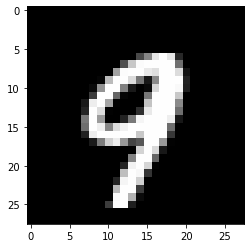

In [37]:
# we can iterate over trainloader in the following way
for inputs, targets in trainloader:
    print(f'Dimensions of the inputs are {inputs.shape}')
    plt.imshow(inputs[0][0], cmap='gray', interpolation='none')
    print(f'The number on the image is: {targets[0]}')
    break

The shape of ```inputs``` is $(32, 1, 28, 28)$. The first dimension indicates the size of the mini batch and is controlled by parameter ```batch_size```, the last two parameters are the 2D dimensions of the image and are equal to $28 \times 28$ in case of the MNIST data. The lonely $1$, staying in the second dimension essentialy reflects the fact that the images are black and white. For instance, if MNIST were colored (there are variants of colored MNIST actually), then we would need $3$ (in case of RGB) colors to represent an image, thus $1$ would be replaced by $3$. 

**Question:** Run the above block several times. Is it plotting the same number all the time? If not, why?

**Answer:** No, because ```torch.utils.data.random_split``` randomly split the dataset all_train into non-overlapping new datasets (trainset and valset).
We can optionally fix the generator for reproducible results, e.g.:
```trainset, valset = torch.utils.data.random_split(all_train, [num_train, len(all_train) - num_train], generator=torch.Generator().manual_seed(42))```

In [38]:
# Net + training parameters
num_epochs = 2 # how many passes over the whole train data
input_size = 784 # flattened size of the image
hidden_sizes = [128, 64] # sizes of hidden layers
output_size = 10 # how many labels we have
lr = 0.001 # learning rate
momentum = 0.9 # momentum

In [39]:
# initializing our model/loss/optimizer
net = SimpleFeedForward(input_size, hidden_sizes, output_size) # Our neural net
criterion = nn.CrossEntropyLoss() # Loss function to be optimized
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum) # Optimization algorithm

In [40]:
# num_epochs indicates the number of passes over the data
for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)


In [79]:
# Let us evaluate our net on the test set that we have never seen!
testset = datasets.MNIST('data/',
                         download=True,
                         train=False,
                         transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.9826 | Test loss: 0.0521137018121779


# Problem 1: Logistic regression via pytorch

Using above code as an example implement multinomial logistic regression and train it on the same data.
For your report include:
1. Mathematical description of logistic regression
2. Mathematical description of optimization algorithm that you use
3. High level idea of how to implement logisitic regression with pytorch
4. Report classification accuracy on test data.

**Answer :**

**1. Mathematical description of logistic regression**

Logistic Regression can be thought of as a simple, fully-connected neural network with one hidden layer.

In the following network (see diagram), the **forward pass** are the three steps from the input to the output layer.

<img src="https://aaronkub.com/images/logistic_regression_diagram.jpg" width="500" height="300"/>

1. The input data in blue are the $n$ features ($n =4$ in the example)
2. In the hidden layer in red are the resulting matrix $Z$ of multiplying each m rows (training observations) of the dataset a weight matrix with n rows and k columns, with $k$ the number of unique classes you want to predict. We also add a bias to the result. The equation is $Z_{[m,k]} = X_{[m,n]} W_{[n,k]} + b_{[m,k]}$. $z_{i,j}$ is called the logit for the $j^{th}$ label of the $i^{th}$ training example

Remark : To represent multinomial classes, we use **one-hot encoding** as we saw for TP2 : a simple transformation of a 1-dimensional vector of length $m$ into a binary tensor of shape $(m, k)$, where k is the number of unique classes. Each column in the new tensor represents a specific class label and for every row there is exactly one column with a 1, everything else is zero. But the PyTorch's loss function that we use (`nn.CrossEntropyLoss`) take directly class labels as their targets so we don't need to convert targets into onehot vectors. 

3. For the output layer in green, every logit of the matrix $Z$ are passed through an activation function called Softmax (equation below) and the results are numbers between 0 and 1. $a_{i,j}$ will correspond to the probability that observation $i$ is of the type $j$.

\begin{equation*}
\sigma_{i}(z_{i,j}) = \frac{e^{z_{i,j}}}{\sum_{n=0}^{k}e^{z_{i,n}}} = a_{i, j}
\end{equation*}

=> Finally, we pick the node in the output layer that has the highest probability and choose that as the predicted class label.

**2. Mathematical description of optimization algorithm that you use**

At the end of each forward pass in the training process, we use the activations to determine the performance of the model using the cost called **Cross Entropy Loss** : $Cross\:Entropy\:Loss = -\frac{1}{m}\sum_{i=0}^{m} \sum_{j=0}^{k} y_{i,j} \cdot \log (a_{i,j})$

*Remark : To prevent the model from overfitting, we can also regularize the regression by simply adding a term to the cost function intended to penalize model complexity. We use : $L2\:Regularized\:Loss = -\frac{1}{m}\sum_{i=0}^{m} \sum_{j=0}^{k} y_{i,j} \cdot \log (a_{i,j}) + \lambda \sum_{i=0}^{n} \sum_{j=0}^{k} w_{i,j}^2$ with $\lambda \leq 0$ a hyperparameter to be tuned. We don't do it here because it is not specifically asked.*

Finally, during the **backward pass**, go back through the network and make adjustments to every hidden layer’s parameters. The goal is to reduce the loss in the next training iteration. In this particular case of Logistic Regression, there’s only one layer of parameters that will get adjusted by a method called **Gradient Descent** : 

1. We first get the gradient of each model parameter using the backpropagation algorithm. 

$$\nabla (W) =
\begin{bmatrix}
\nabla (w_{0,0}) & \nabla (w_{0,1}) & \cdots & \nabla (w_{0,k}) \\
\nabla (w_{1,0}) & \nabla (w_{1,1}) & \cdots & \nabla (w_{1,k}) \\
\vdots  & \vdots  & \cdots & \vdots \\
\nabla (w_{n,0}) & \nabla (w_{n,1}) & \cdots & \nabla (w_{n,k})
\end{bmatrix} \qquad \text{where} \qquad \nabla (w_{f,l}) = 
[\frac{1}{m} \sum_{i=0}^{m} \left( x_{i,f} * (y_{i, l} - a_{i, l}) \right)] + [2 \lambda * w_{f,l}]$$

$$\nabla (b) = 
\begin{bmatrix}
\nabla (b_{0}) & \nabla (b_{1}) & \cdots & \nabla (b_{k})
\end{bmatrix} \qquad \text{where} \qquad \nabla (b_{l}) = \frac{1}{m} \sum_{i=0}^{m} \left( y_{i, l} - a_{i, l} \right)$$

2. We update each model parameter in the opposite direction of its gradient.

*Source : [here](https://aaronkub.com/2020/02/12/logistic-regression-with-pytorch.html) and [here](https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19)*


**3. High level idea of how to implement logisitic regression with pytorch**

**Preliminary remark:** In the function `train` constructed by the teacher, there was a little mistake that we had to correct so that the following code works. The following line...

            #careful : the following line was a mistake in the teacher's proposition ! 
            #outputs = net(inputs) # mistake we need to replace net by the parameter "model"

had been replaced by...

            outputs = model(inputs) # Forwards stage (prediction with current weights)
            
          

In [62]:
# Add multinomial logistic regression
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.classifier = torch.nn.Linear(input_size, output_size)
        # We don't use Softmax here because the CrossEntropyLoss function computes softmax before the CE.

    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.classifier(x)
        return x

In [63]:
# initializing our model/loss/optimizer
MLR = MultinomialLogisticRegression(input_size, output_size) 
criterion = nn.CrossEntropyLoss() # /!\ computes softmax and then the cross entropy
optimizer = optim.SGD(MLR.parameters(), lr=lr)

In [64]:
# num_epochs indicates the number of passes over the data
for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(MLR, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(MLR, valloader, criterion)


**4. Report classification accuracy on test data.**

**=> The accuracy is 83 % with 2 epochs on test data.**

In [65]:
# Let us evaluate our net on the test set that we have never seen!
testset = datasets.MNIST('data/',
                         download=True,
                         train=False,
                         transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_loss, test_acc = validation(MLR, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.83 | Test loss: 0.9829374759674072


# Elements of CNN: ```nn.Conv2d``` and ```MaxPool2d```

Read this before starting: https://ttic.uchicago.edu/~shubhendu/Pages/Files/Lecture7_flat.pdf

In [ ]:
# reload the data
all_train = datasets.MNIST('data/',
                           download=True,
                           train=True,
                           transform=transforms.ToTensor())

# We split the whole train set in two parts:
# the one that we actually use for training
# and the one that we use for validation
batch_size = 32 # size of the mini batch
num_train = int(0.8 * len(all_train))

trainset, valset = torch.utils.data.random_split(all_train, [num_train, len(all_train) - num_train])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [73]:
# Net + training parameters
num_epochs = 2 # how many passes over the whole train data
input_size = 784 # flattened size of the image
hidden_sizes = [128, 64] # sizes of hidden layers
output_size = 10 # how many labels we have
lr = 0.001 # learning rate
#momentum = 0.9 # momentum

**Understanding the convolutional layer in pytorch**

Once we instanciate ```nn.Conv2d(1, 1, kernel_size=2, stride=[1, 1], padding=0)``` it has a parameter ```weight``` which precisely describes the kernel used for our convolution. In the beginning it is initialized randomly, and our goal is to eventually learn its weights (as usual via backpropagation!).
Before building our first CNN let us have a look at the kernel and what it does.

In [7]:
# 1 input channel (first 1 in nn.Conv2d)
# 1 output channel (second 1 in nn.Conv2d)
# 2x2 kernel (kernel_size=2)
# the kernel slides by one step in (x, y) direction (stride=[1, 1])
# we do not augment the picture with white borders (padding=0)
conv = nn.Conv2d(1, 1, kernel_size=2, stride=[1, 1], padding=0) 
# Get kernel value.
weight = conv.weight.data.numpy()
weight

array([[[[-0.32727212,  0.08143073],
         [-0.4342568 ,  0.35001594]]]], dtype=float32)

**Visualization.** We will plot the initial image, the kernel, and the resulting image. In order to understand what is going on, the resulting image will be computed in two ways. First of all it will be computed by using ```conv1(image)```. Secondly, we will manually apply the sliding kernel to each $2\times 2$ window.

Text(0.5, 1.0, 'By hand')

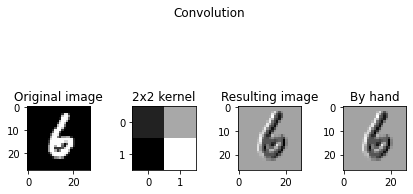

In [17]:
# take one image
image, _ = next(iter(trainloader))
fig, axs = plt.subplots(1, 4)
fig.tight_layout()
fig.suptitle('Convolution')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')

# plot the kernel
axs[1].imshow(weight[0][0], cmap='gray', interpolation='none')
axs[1].set_title('2x2 kernel')

# plot resulting image
axs[2].imshow(conv(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[2].set_title('Resulting image')

# Making the same by hands
# IMPORTANT: we strongly suggest to understand the below code
np_image = image[0][0].data.numpy() # get numpy image
image_convolved = np.zeros((27, 27)) # here we store our result
for i in range(27):
    for j in range(27):
        image_convolved[i, j] = np.sum(np_image[i:i+2, j:j+2] * weight) # apply the kernel for each 2x2 window
        
axs[3].imshow(image_convolved, cmap='gray', interpolation='none')
axs[3].set_title('By hand')

In [57]:
# Zoom to understand the code
np_image = image[0][0].data.numpy() # get numpy image
print(np_image.shape) #28x28
print(np_image[2]) #valeur des pixels de la 4e ligne !
image_convolved = np.zeros((28, 28)) #on fait une image (27x27? => 28x28) avec que des 0. 
print(image_convolved.shape)
for i in range(28):
    for j in range(28):
        if((j==10 and i==11) or (j==10 and i==10) or (j==11 and i==11) or(j==11 and i==10) ):
            print("i:",i," j:",j)
            print("3 carrés adjacent au pixel considéré : np_image[i:i+2, j:j+2]:",np_image[i:i+2, j:j+2])
        image_convolved[i, j] = np.sum(np_image[i:i+2, j:j+2] * weight) # apply the kernel for each 2x2 window

(28, 28)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(28, 28)
i: 10  j: 10
3 carrés adjacent au pixel considéré : np_image[i:i+2, j:j+2]: [[0.         0.16078432]
 [0.         0.44313726]]
i: 10  j: 11
3 carrés adjacent au pixel considéré : np_image[i:i+2, j:j+2]: [[0.16078432 0.9529412 ]
 [0.44313726 0.99215686]]
i: 11  j: 10
3 carrés adjacent au pixel considéré : np_image[i:i+2, j:j+2]: [[0.         0.44313726]
 [0.32156864 0.9137255 ]]
i: 11  j: 11
3 carrés adjacent au pixel considéré : np_image[i:i+2, j:j+2]: [[0.44313726 0.99215686]
 [0.9137255  0.9882353 ]]


Text(0.5, 1.0, 'By hand')

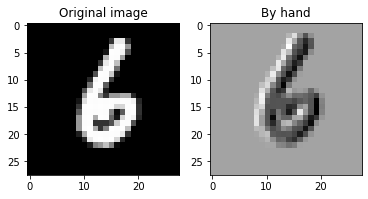

In [58]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')
axs[1].imshow(image_convolved, cmap='gray', interpolation='none')
axs[1].set_title('By hand')


**Problem.** Provide 'by hand' implementation of the following kernel 

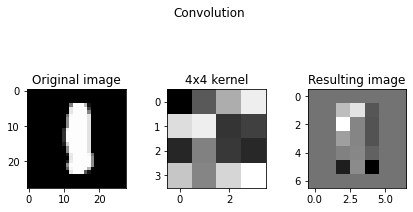

In [61]:
# 1 input channel (first 1 in nn.Conv2d)
# 1 output channel (second 1 in nn.Conv2d)
# 4x4 kernel (kernel_size=4) (before it was 2x2)
# the kernel slides by 3 step in (x, y) direction (stride=[4, 4]) (before : 1 step stride [1,1])
# we do not augment the picture with white borders (padding=0)

conv = nn.Conv2d(1, 1, kernel_size=4, stride=[4, 4], padding=0) 
# Get kernel value.
weight = conv.weight.data.numpy()

# take one image
image, _ = next(iter(trainloader))


fig, axs = plt.subplots(1, 3) #correction (1,4) before
fig.tight_layout()
fig.suptitle('Convolution')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')

# plot the kernel
axs[1].imshow(weight[0][0], cmap='gray', interpolation='none')
axs[1].set_title('4x4 kernel')

# plot resulting image
axs[2].imshow(conv(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[2].set_title('Resulting image')

# Making the same by hands
# PROBLEM: FILL IN THIS PART. 
np_image = image[0][0].data.numpy() # get numpy image

**Understanding the pooling layer in pytorch**

Max pooling is what often used in practice, it amounts to picking only the largest value of a pixel in a given window. In pytorch it is done via ```MaxPool2d(kernel_size=k, stride=s)```, which has two parameters: kernel size and the stride. Note that there are no weights to learn here, so this layer is simply fixed.

Text(0.5, 1.0, 'By hand')

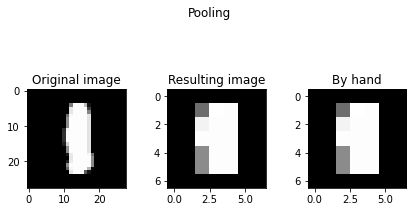

In [62]:
# kernel_size -- size of the max pool window
pool = nn.MaxPool2d(kernel_size=4, stride=[4,4])

fig, axs = plt.subplots(1, 3)
fig.tight_layout()
fig.suptitle('Pooling')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')


# plot resulting image
axs[1].imshow(pool(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[1].set_title('Resulting image')

# Making the same by hands
# IMPORTANT: we strongly suggest to understand the below code
np_image = image[0][0].data.numpy() # get numpy image
image_pooled = np.zeros((7, 7)) # here we store our result
for i in range(0, 27, 4):
    for j in range(0, 27, 4):
        image_pooled[int(i / 4), int(j / 4)] = np.max(np_image[i:i+4, j:j+4]) # max pooling
        
axs[2].imshow(image_pooled, cmap='gray', interpolation='none')
axs[2].set_title('By hand')

# Bulding a simple ConvNet

In [71]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=[1, 1], padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Sequential(
            nn.Linear(14 * 14 * 8, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

Note that the first layer is ```nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)```, the parameters here are chosen in such a way that the size of each output channel remains as $28 \times 28$. Indeed, setting ```padding = 2``` we augmented our initial image to $32 \times 32$, then we slide a kernel of size $5 \times 5$ by $1$ in both $(x, y)$ directions which result in a $28 \times 28$ output image (and $8$ channels).

In general the formula for square images and squared kernels is
$$
    S_{out} = \frac{S_{in} - S_{kernel} + 2S_{padding}}{S_{stride}} + 1
$$

In our case it is

$$
    S_{out} = \frac{28 - 5 + 4}{1} + 1 = 28
$$

Then the output of ```nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2)``` goes into ```nn.ReLU()``` our favorite non-linearity and eventually into the pooling layer ```nn.MaxPool2d(kernel_size=2, stride=2)```.
The ```nn.ReLU()``` doe not affect the size, hence ```nn.MaxPool2d(kernel_size=2, stride=2)``` receives $8$ channels of $28 \times 28$ images as computed above.

```nn.MaxPool2d(kernel_size=2, stride=2)``` will be applied to each single channel, with ```kernel_size=2, stride=2``` meaning that the output will still have $8$ channels but the images will be halfed in both $(x, y)$ directions. Hence the output of ```nn.MaxPool2d(kernel_size=2, stride=2)``` has $8$ channels with $14 \times 14$ images.

After all this, we will flatten our features and put the into simple ```nn.Linear(14 * 14 * 8, 500)```, where the input size is precisely the output size of ```nn.MaxPool2d(kernel_size=2, stride=2)```, and $500$ stands for the output size of this linear layer.
Finally, we apply our favorite nonlinearity to ```nn.Linear(14 * 14 * 8, 500)``` followed by fully connected linear layer ```nn.Linear(500, 10)``` to match the dimension of $10$ classes.

In [76]:
net = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)

In [80]:
test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.9826 | Test loss: 0.052113702251017094


As you see the result here is much better, than in the simple multilayer perceptron. But note, we have actualy trained muuuuuch more parameters here and, at least on my computer, it takes considerably more time.

Here you can see the summary of current state of the art results on MNIST: https://www.kaggle.com/c/digit-recognizer/discussion/61480

As you see our score barely beats a carefully built random forest or **kNN**! To get extra $0.01$ requires much more fine tuning, which is of course is not the goal here.

# Problem 2: Dropout

Modify the code for ConvNet and insert Dropout layer (whereever you want).

Include in your report:
1. High level description of the dropout
2. High level description of your architechture

**Answer:**

**1. High level description of the dropout**

The idea of "Dropout" is to prevent from overfitting in deep neural network with large parameters on the data. As you can see in the following figure, "Dropout" deactivates the neurons randomly at each training step instead of training the data on the original network, we train the data on the network with dropped out nodes. In the next iteration of the training step, the hidden neurons which are deactivated by dropout changes because of its probabilistic behavior. In this way, by applying dropout i.e…deactivating certain individual nodes at random during training we can simulate an ensemble of neural network with different architectures.

<img src="https://miro.medium.com/max/612/1*S-Rr9boTfKusUzETeKW6Mg.png" width="500" height="300"/>

In Pytorch, we simply need to introduce `nn.Dropout` layers specifying the rate at which to drop (i.e. zero) units. Learning a neural network with dropout is usually slower than without dropout. 

*Source : [here](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)*

**2. High level description of your architechture**


<mark>TODO : décrire qu'on a testé plusieurs types de modèles et décrire l'architecture de chacun d'eux ainsi que l'accuracy obtenu. L'idéal serait d'accompagner cela d'un graphique pour montrer l'amélioration de l'architecture que nous proposons (diminution de l'overfitting par ex...)</mark>



<mark> @Isabelle. J'ai testé plusieurs modèles convolutifs avec dropout. Les résultats chiffré sont dans le dernier paragraphe de Bilan avec des suggestions sur les modèles à conserver ou non. Ce que je vois qu'il rester à faire par exemple : </mark>

1. <mark>Finir la rédaction de cette partie en répondant à la partie 2. High level description of your architechture</mark>

2. <mark>Faire (éventuellement, si pertinent) un graphique en comparant Conv avec Conv4/Conv5 ? pour montrer pédagogiquement la baisse de l'overfitting permise par Conv4/Conv5 ? Je pense que faire ce graphique n'est pas une mince affaire car il demande à modifier le code. J'ai mis dans mon brouillon quelques sources d'inspiration pour faire des graphiques et quelques pistes en vrac... Mais la plupart des graphiques que je vois mettent les epoch en abscisse or nous on a que 2 epochs dans nos tests donc je ne sais pas si c'est adapté... A voir... </mark>


In [99]:
#On teste juste d'ajouter dropout de 0.5 avant la couche linéaire 
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=[1, 1], padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), #NEW DROPOUT = 50 % probability 
            nn.Linear(14 * 14 * 8, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

In [90]:
# Inspiré de version Vanilla d'ici :
#https://github.com/jeremyfix/deeplearning-lectures/blob/master/LabsSolutions/00-pytorch-FashionMNIST/models.py
class ConvNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential( #before = layer1
            nn.Conv2d(1, 16,kernel_size=5,stride=1,padding=int((5-1)/2), bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32,kernel_size=5,stride=1,padding=int((5-1)/2), bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64,kernel_size=5,stride=1,padding=int((5-1)/2), bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        probe_tensor = torch.zeros((1,1,28,28))
        out_features = self.layer1(probe_tensor).view(-1)
        num_classes = 10 
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(out_features.shape[0], 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    

In [96]:
# Inspiré de version d'ici :
#https://github.com/nagadakos/ml-repo/blob/master/PyTorch/KerasMirror_Pytorch.py
class ConvNet4(nn.Module):
    def __init__(self):
        super().__init__()
        num_classes = 10 
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.drop = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(64*144, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = self.drop(F.max_pool2d(F.relu(self.conv2(x)), 2))
        # x = self.drop(x)
        x = x.view(-1, 64*144)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x
    
    

In [107]:
# Inspiré de version Fancy d'ici :
#https://github.com/jeremyfix/deeplearning-lectures/blob/master/LabsSolutions/00-pytorch-FashionMNIST/models.py

def conv_bn_relu(in_channels, out_channels, ks):
    return [nn.Conv2d(in_channels, out_channels,
                  kernel_size=ks,
                  stride=1,
                  padding=int((ks-1)/2), bias=True),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)]
    
class ConvNet5(nn.Module):

    def __init__(self):
        super().__init__()
        num_classes = 10
        base_n = 64
        self.features = nn.Sequential(
            *conv_bn_relu(1, base_n, 3),
            *conv_bn_relu(base_n, base_n, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.4),
            *conv_bn_relu(base_n, 2*base_n, 3),
            *conv_bn_relu(2*base_n, 2*base_n, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.4),
            *conv_bn_relu(2*base_n, 4*base_n, 3),
            *conv_bn_relu(4*base_n, 4*base_n, 3),
            nn.AvgPool2d(kernel_size=7)
        )

        self.lin1 = nn.Linear(4*base_n, num_classes)

    def forward(self, x):
        x  = self.features(x)
        x = x.view(x.size()[0], -1)
        y = self.lin1(nn.functional.dropout(x, 0.5, self.training, inplace=True))
        #y = self.classifier(x)
        return y

In [123]:
net = ConvNet5() #test the model of our choice ConvNetX (2 to 5)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)
    

In [110]:
test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.9912 | Test loss: 0.027332775755273177


=> **Bilan actuel des modèles qui ont tourné (tous sur 2 epochs) :**

- Avec Conv : 98,3 % d'accuracy et très rapide => baseline
- Avec Conv2 : 98,3 % d'accuracy et rapide => Conserver à but pédagogique et dire qu'on va ensuite compliquer un peu le modèle
- Avec Conv3 : 98,9 % d'accuracy et lent => Conserver ? bon compromis entre vitesse et accuracy ? Car moins lent que Conv4 ? 
- Avec Conv4 : 98,4 % d'accuracy et lent => Ne pas conserver
- Avec Conv5 : 99,1 % d'accuracy et trèèèèès lent (40min)  => Conserver = meilleur modèle jusqu'à présent.


# Conclusion

After the succesful completion of this TP, we expect you to be able to understand the architectures of NN, CNN.
For instance, have a look at the famous AlexNet https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py and see if you can understand its architechture.

# Tout ce qu'il y a ci-dessous : Brouillon Kim à supprimer plus tard

Let's calculate the critical points of the function $f$ which are such as $\frac{\partial f}{\partial w_1}(w) = \dots = \frac{\partial f}{\partial w_5}(w) = 0$

with $\forall i \in \{1, \dots, 5\}$, $\frac{\partial f}{\partial w_i}(w) = -2 (1-\sum_{k=1}^5 w_k$). So the critical points are all the points $w=(w_1, \dots, w_5)$ such that $\sum_{k=1}^5 w_k = 1$ 


**References qui peuvent servir**

Isabelle: 

Exemples de code que lequel je me suis inspirée mais en restant proche du code du prof car ces codes diffèrent énormément : https://github.com/liaison/Multinomial-Logistic-Regression/blob/master/MNL.py et : https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/logistic_regression/main.py


Kim:

HI, it depends on your loss function, but some PyTorch’s loss functions take class labels as their targets(e.g. NLLloss 3.8k). So if you use them, you don’t need to convert targets into onehot vectors.
https://www.programcreek.com/python/example/105103/torchvision.datasets.MNIST

https://nextjournal.com/gkoehler/pytorch-mnist

=> https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19 tentative solution



**Tests pour les graphiques : non aboutis**

In [1]:
def validation2(model, valloader, loss):
    # Do not compute gradient, since we do not need it for validation step
    with torch.no_grad():
        # We enter evaluation mode.
        model.eval()
        
        total = 0 # keep track of currently used samples
        running_loss = 0.0 # accumulated loss without averagind
        accuracy = 0.0 # accumulated accuracy without averagind (number of correct predictions)
        
        loop = tqdm(valloader) # This is for the progress bar
        loop.set_description('Validation in progress')
        test_acc_vec = []
        test_loss_vec = [] 
        
        # We again iterate over the batches of validation data. batch_size does not play any role here
        for inputs, targets in loop:
            # Run samples through our net
            outputs = model(inputs)

            # Total number of used samples
            total += inputs.shape[0]

            # Multiply loss by the batch size to erase averagind on the batch
            running_loss += inputs.shape[0] * loss(outputs, targets).item()
            
            # how many correct predictions
            accuracy += (outputs.argmax(dim=1) == targets).sum().item()
            
            #NEW
            test_loss = running_loss / total
            test_acc = accuracy / total
            test_loss_vec.append(test_loss)
            test_acc_vec.append(test_acc)
            
            # set nice progress meassage
            loop.set_postfix(val_loss=(running_loss / total), val_acc=(accuracy / total))
                       
        return test_loss, test_acc, test_loss_vec, test_acc_vec

In [ ]:
labels = ['Conv', 
          'Conv2']

plt.figure(figsize=(8, 7))
plt.plot(range(1, len(r)+1), r, '.-', label="Conv", alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('iteration');
plt.ylabel('Accuracy in test set');
plt.title('Accuracy on MNIST dataset with the different Convolutional networks')
plt.show()


In [ ]:
#save the results of the models if it is long to implement. 
import pickle
with open("data/sauv_proj/test_loss_vec_conv5.txt", "wb") as fp:   #Pickling
    pickle.dump(test_loss_vec, fp)
with open("data/sauv_proj/test_acc_vec_conv5.txt", "wb") as fp:   #Pickling
    pickle.dump(test_acc_vec, fp)
with open("data/sauv_proj/test_acc_vec_conv5.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
b

**Compléter les recherches sur les réseaux convolutifs avec des éléments piochés dans cette biblio ?**

https://www.kaggle.com/c/digit-recognizer/discussion/61480 (ici ils disent les modèles les plus performants notamment celui qui atteint 99 % avec un dropout) => essayer de le reproduire. 

https://teaching.pages.centralesupelec.fr/deeplearning-lectures-build/00-pytorch-fashionMnist.html

https://nagadakos.github.io/2018/09/23/dropout-effect-discussion/

https://github.com/jeremyfix/deeplearning-lectures/blob/master/LabsSolutions/00-pytorch-FashionMNIST/data.py (code des solutions)

https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/ (pour rajouter un graphique de l'amélioration de l'overfitting)

https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist (autre exemples de graphiques)

https://github.com/nagadakos/ml-repo/blob/master/PyTorch/KerasMirror_Pytorch.py ajouter history dans les codes pour faire les plots

"In their original paper, Srivastava et al. 2014 suggest for example Dropping out 20% of the input units and 50% of the hidden units was often found to be optimal. "